In [225]:
from socket import error as socket_error
from urllib.request import urlopen
from dns.query import udp, tcp
from bs4 import BeautifulSoup
from dns.resolver import dns
from uuid import uuid4
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib as plt

import subprocess
import socket
import copy
import time
import json
import csv
import os

%matplotlib inline

In [209]:
pie = (6, 6)

In [2]:
def write_list(fn, data):
    '''Writes a list to a file with each value on a new line'''
    with open(fn, 'w') as f:
        for datum in data:
            f.write(datum + newline)
        
def append_list(fn, data):
    '''Appends a list to a file with each value on a new line'''
    with open(fn, 'a') as f:
        for datum in data:
            f.write(datum + newline)
    
def read_list(fn):
    '''Reads a file and '''
    with open(fn, 'r') as f:
        return [line.strip(newline) for line in f]
    
def write_json(fn, data):
    with open(fn, 'w') as f:
        f.write(json.dumps(data))
            
def read_json(fn):
    '''Read a json file (fn) and returns it as a dictionary'''
    with open(fn, 'r') as f:
        return json.loads(f.read())

# Top-Level Domains

In [172]:
data_tlds = read_json('data/data_tlds.json')

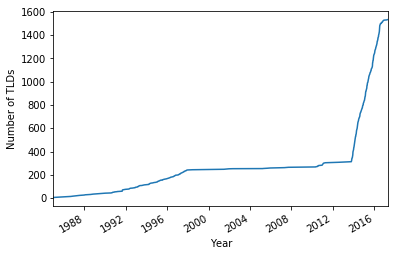

In [173]:
df_tlds = pd.DataFrame(data_tlds)
df_tlds['creation_date'] = pd.to_datetime(df_tlds['creation_date'])
ax = df_tlds.creation_date.value_counts().sort_index().cumsum().plot()
ax.set_xlabel("Year")
ax.set_ylabel('Number of TLDs')
fig = ax.get_figure()
fig.savefig("imgs/tld_growth.pdf")

In [259]:
df_tlds.

,creation_date,organisations,tld
0,2015-08-13,"[ American Automobile Association, Inc., Mark...",AAA
1,2015-10-22,"[ AARP, FairWinds Partners, LLC, Verisign, I...",AARP
2,2016-07-14,"[ Fiat Chrysler Automobiles N.V., FCA Italy S...",ABARTH
3,2015-04-09,"[ ABB Ltd, ABB Schweiz AG, Verisign, Inc.]",ABB
4,2014-11-20,"[ Abbott Laboratories, Inc., FairWinds Partne...",ABBOTT


In [196]:
new_tlds = df_tlds[(df_tlds.creation_date >= '2013-10-23')].tld
old_tlds = df_tlds[(df_tlds.creation_date < '2013-10-23')].tld

In [197]:
tld_groups = {'all': df_tlds.tld, 'old': old_tlds, 'new': new_tlds}

# Name Servers

In [175]:
data_nss = read_json('data/data_ns.json')

In [176]:
df_nss = pd.DataFrame(data_nss)
maxc = df_nss.tld.value_counts().max()
minc = df_nss.tld.value_counts().min()

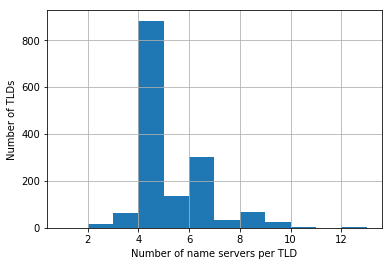

In [177]:
ax = df_nss.tld.value_counts().hist(bins = maxc - minc, range = (minc, maxc))
ax.set_ylabel('Number of TLDs')
ax.set_xlabel('Number of name servers per TLD')
fig = ax.get_figure()
fig.savefig("imgs/nss_per_tld.pdf")

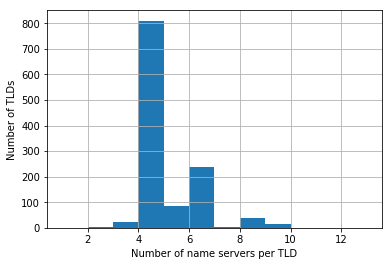

In [178]:
ax = df_nss[df_nss.tld.isin(new_tlds)].tld.value_counts().hist(bins = maxc - minc, range = (minc, maxc))
ax.set_ylabel('Number of TLDs')
ax.set_xlabel('Number of name servers per TLD')
fig = ax.get_figure()
fig.savefig("imgs/nss_per_tld_new.pdf")

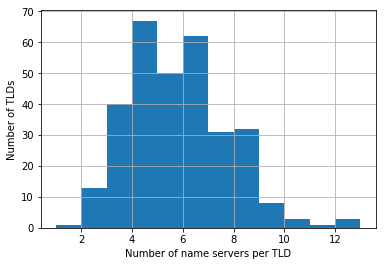

In [179]:
ax = df_nss[df_nss.tld.isin(old_tlds)].tld.value_counts().hist(bins = maxc - minc, range = (minc, maxc))
ax.set_ylabel('Number of TLDs')
ax.set_xlabel('Number of name servers per TLD')
fig = ax.get_figure()
fig.savefig("imgs/nss_per_tld_old.pdf")

# Network Diversity

In [185]:
data_asns = read_json('data/data_asns.json')
data_ips = read_json('data/data_ips.json')

In [186]:
df_asns = pd.DataFrame(data_asns)

In [192]:
maxc = df_asns.groupby('tld').asn.nunique().max()
minc = df_asns.groupby('tld').asn.nunique().min()

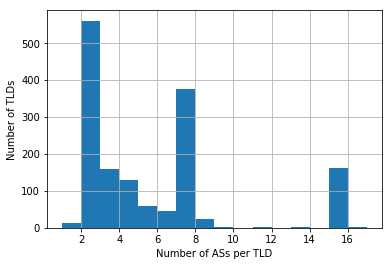

In [193]:
ax = df_asns.groupby('tld').asn.nunique().hist(bins = maxc - minc, range = (minc, maxc))
ax.set_ylabel('Number of TLDs')
ax.set_xlabel('Number of ASs per TLD')
fig = ax.get_figure()
fig.savefig("imgs/asns_per_tld.pdf")

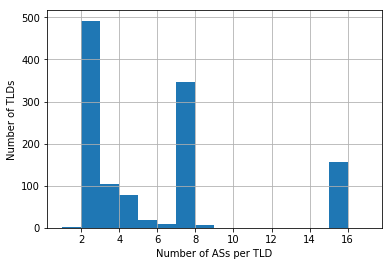

In [194]:
ax = df_asns[df_asns.tld.isin(new_tlds)].groupby('tld').asn.nunique().hist(bins = maxc - minc, range = (minc, maxc))
ax.set_ylabel('Number of TLDs')
ax.set_xlabel('Number of ASs per TLD')
fig = ax.get_figure()
fig.savefig("imgs/asns_per_tld_new.pdf")

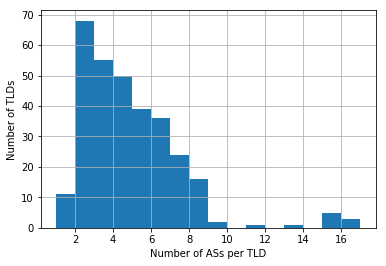

In [195]:
ax = df_asns[df_asns.tld.isin(old_tlds)].groupby('tld').asn.nunique().hist(bins = maxc - minc, range = (minc, maxc))
ax.set_ylabel('Number of TLDs')
ax.set_xlabel('Number of ASs per TLD')
fig = ax.get_figure()
fig.savefig("imgs/asns_per_tld_old.pdf")

In [198]:
maxc = df_asns.groupby('asn').tld.nunique().max()
minc = df_asns.groupby('asn').tld.nunique().min()

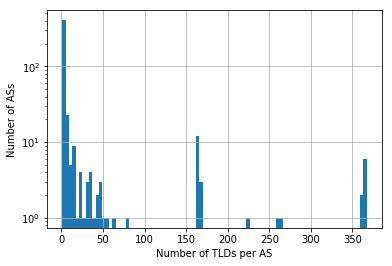

In [199]:
ax = df_asns.groupby('asn').tld.nunique().hist(bins = int((maxc - minc) / 4), range=(minc, maxc))
ax.set_yscale('log')
ax.set_ylabel('Number of ASs')
ax.set_xlabel('Number of TLDs per AS')
fig = ax.get_figure()
fig.savefig("imgs/tlds_per_asn.pdf")

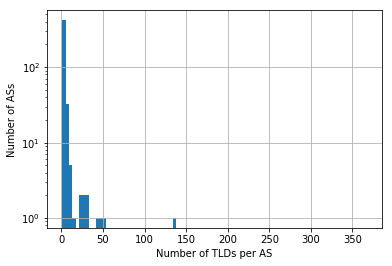

In [170]:
ax = df_asns[df_asns.tld.isin(old_tlds)].groupby('asn').tld.nunique().hist(bins = int((maxc - minc) / 4),
                                                                           range=(minc, maxc))
ax.set_yscale('log')
ax.set_ylabel('Number of ASs')
ax.set_xlabel('Number of TLDs per AS')
fig = ax.get_figure()
fig.savefig("imgs/tlds_per_asn_old.pdf")

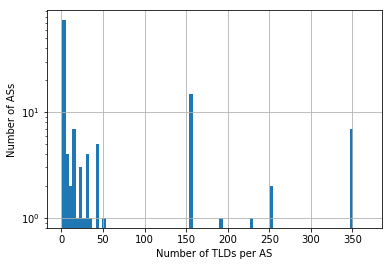

In [200]:
ax = df_asns[df_asns.tld.isin(new_tlds)].groupby('asn').tld.nunique().hist(bins = int((maxc - minc) / 4),
                                                                           range=(minc, maxc))
ax.set_yscale('log')
ax.set_ylabel('Number of ASs')
ax.set_xlabel('Number of TLDs per AS')
fig = ax.get_figure()
fig.savefig("imgs/tlds_per_asn_new.pdf")

# Credibility

In [215]:
data_cred = read_json('data/data_cred.json')

In [227]:
!wget https://www.iana.org/assignments/dns-sec-alg-numbers/dns-sec-alg-numbers-1.csv -O data/lists/dnssec_algorithm_numbers.csv
reader = csv.reader(open('data/lists/dnssec_algorithm_numbers.csv', 'r'))

--2017-06-14 14:20:12--  https://www.iana.org/assignments/dns-sec-alg-numbers/dns-sec-alg-numbers-1.csv
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving www.iana.org... 2620:0:2d0:200::8, 192.0.32.8
Connecting to www.iana.org|2620:0:2d0:200::8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘data/lists/dnssec_algorithm_numbers.csv’

data/lists/dnssec_a     [ <=>                ]   1.52K  --.-KB/s    in 0s      

2017-06-14 14:20:13 (8.03 MB/s) - ‘data/lists/dnssec_algorithm_numbers.csv’ saved [1559]



In [228]:
df_cred = pd.DataFrame(data_cred)

In [229]:
algorithms = {}

for row in reader:
   k, _, v, _, _, _ = row
   algorithms[k] = v

In [232]:
for algorithm_number in algorithms:
    df_cred['algorithm'] = df_cred['algorithm'].replace(algorithm_number, algorithms[algorithm_number])

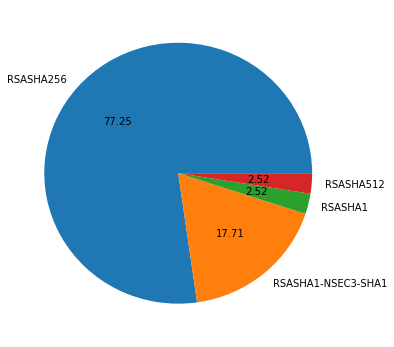

In [247]:
ax = df_cred.algorithm.value_counts().plot.pie(figsize = pie, autopct='%.2f')
ax.set_ylabel("")
fig = ax.get_figure()
fig.savefig("imgs/dnssec_algs.pdf")

In [256]:
dnssec_record_counts = [df_cred.loc[df_cred.dnskey == x].loc[df_cred.ds == y].count().tld 
                        for x in [True, False] for y in [True, False]]

df_cred2 = pd.DataFrame(dnssec_record_counts, 
                        columns = ['dnssec_record_counts'],
                        index = ['ds + dnskey', 'ds', 'dnskey', 'none'])

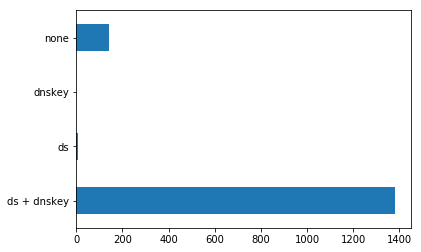

In [257]:
df_cred2.dnssec_record_counts.plot.barh()
ax.set_ylabel('Available records')
ax.set_xlabel('Number of TLDs')
fig = ax.get_figure()
fig.tight_layout()
fig.savefig("imgs/dnssec.pdf")

In [258]:
df_cred.loc[df_cred.dnskey == False].loc[df_cred.ds]

,algorithm,dnskey,ds,tld
1448,None,False,True,XN--MGBAI9AZGQP6J


# Performance